In [1]:
# Standard stuff
import numpy as np                              #For almost everything
import matplotlib.pyplot as plt                 #For plotting
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf

#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                           
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
#********************************************************************************************************
figlist=[]

In [2]:
# Nice colors and alphas (https://xkcd.com/color/rgb/)
tcolor  = '#d62728' # color of each sweep
mcolor  = '#040273'  #'#1f3b4d' # color of the median
uncolor = '#040273' # color of uncertainty bars

alpha1 = 0.1  # sweeps transparency
alpha2 = 0.8  # medians
alpha3 = 0.4  # uncertainties

import os

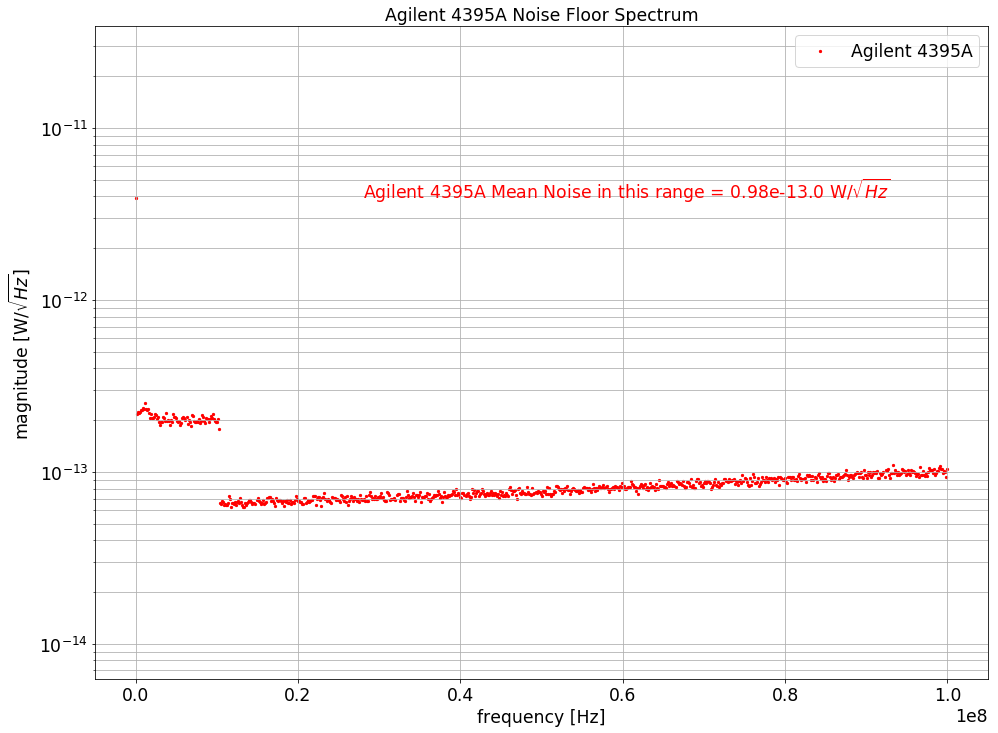

In [3]:
#Agilent 4395A Noise Floor Spectrum for calibration
filename = 'AG4395_Dark_Noise_Spectrum_08-10-2018_125652.txt'
IFBW=10000
Measfreq, MeasMag = np.loadtxt(filename).transpose()
DNCalFig = plt.figure(figsize=(16,12))
plt.grid('on',which='both')
DNCal =  np.sqrt((((MeasMag**2)/50.0)**2)/IFBW)
minRange = np.min(DNCal)
maxRange = np.max(DNCal)
plt.scatter(Measfreq, DNCal,5,'r')
DNCalFig.axes[0].set_ylabel('magnitude [W/$\sqrt{Hz}$]')
DNCalFig.axes[0].set_xlabel('frequency [Hz]')
DNCalFig.axes[0].set_title('Agilent 4395A Noise Floor Spectrum')
DNCalFig.axes[0].set_yscale('log')
xlims = DNCalFig.axes[0].get_xlim()
textX = (xlims[1]-xlims[0])*0.3 + xlims[0]
meanNoise = np.mean(DNCal)
meanNoiseExp = np.round(np.log10(meanNoise),0)
meanNoiseMan = np.round(meanNoise/(10**meanNoiseExp),2)
DNCalFig.axes[0].text(textX,maxRange,'Agilent 4395A Mean Noise in this range = '+str(meanNoiseMan)+'e'+str(meanNoiseExp)+' W/$\sqrt{Hz}$',fontsize='xx-large',color='r')

DNCalFig.axes[0].legend(['Agilent 4395A'])
DNCalFig.axes[0].set_ylim([minRange*0.1,maxRange*10])

plt.savefig('Agilent43951A_Noise_Floor.pdf',bbox_inches='tight', pad_inches=0.2)

In [4]:
def stitch(fileroot,num=25):
    cp = os.getcwd()
    fl =os.listdir(cp)
    selList = []
    for fn in fl:
        if fn.find(fileroot) is not -1:
            selList += [fn]
    for ii in range(num):
        for fn in selList:
            if fn.find('_LF__'+str(ii)+'_') is not -1:
                LF_file = fn
            elif fn.find('_HF__'+str(ii)+'_') is not -1:
                HF_file = fn
        with open(LF_file) as f:
            LF_lines = f.readlines()
        with open(HF_file) as f:
            HF_lines = f.readlines()
        
        TF_file1 = LF_file.replace('_LF_','_TF_')
        TF_file1 = TF_file1.replace('.txt','_')
        TF_file2 = HF_file[-21:]
        with open(TF_file1+TF_file2, 'w') as f:
            f.writelines(LF_lines[0:-1]+HF_lines)        

In [5]:
def plotLikeIris(fileroot, plotTitle,EPL, EPLUnc, PDVdc, PDVdcUnc, RefVdc, RefVdcUnc, PDZdc, PDZdcUnc, RefZdc = 10000, RefZdcUnc=10, RefZac = 700, RefZacUnc=7, xScaler = 1, yScaler=1, freqPower = 0, IFBW=10000):
    #Blunt Iris rip-off because I can't get it to work!

    PhotoCurrentRatio = ((RefVdc/RefZdc)/(PDVdc/PDZdc))
    PhotoCurrentRatioUnc = PhotoCurrentRatio*np.sqrt((RefVdcUnc/RefVdc)**2 + (RefZdcUnc/RefZdc)**2 + (PDVdcUnc/PDVdc)**2 + (PDZdcUnc/PDZdc)**2)

    # Nice colors and alphas (https://xkcd.com/color/rgb/)
    tcolor  = '#d62728' # color of each sweep
    mcolor  = '#040273'  #'#1f3b4d' # color of the median
    uncolor = '#040273' # color of uncertainty bars

    alpha1 = 0.1  # sweeps transparency
    alpha2 = 0.8  # medians
    alpha3 = 0.4  # uncertainties

    ###     Argument Defaults     ###
    #################################

    xAxisLabel  = 'Frequency [Hz]'
    yAxisLabel  = 'Magnitude [V/A]'
    y2AxisLabel = 'Relative Mag [\%]'
    y3AxisLabel = 'Phase [deg]' # Set y2 axis label
    y4AxisLabel = 'Relative Phase [deg]'

    plotLeftTitle  = 'Transimpedance Measurements $\pm$ Uncertainty'
    plotRightTitle = 'Relative Meas $\pm$ Uncertainty'
    plotSaveName = fileroot
    ################################


    cp = os.getcwd()
    fl =os.listdir(cp)
    selList = []
    for fn in fl:
        if fn.find(fileroot+'_TF_') is not -1:
            selList += [fn]
    plotDict = {}
    plotShapeDict = {}
        
    #Making magnitude unitful
    unitFull = RefZac*PhotoCurrentRatio                      #V/A
    unitFullUnc = unitFull*np.sqrt( (RefZacUnc/RefZac)**2 + (PhotoCurrentRatioUnc/PhotoCurrentRatio)**2)
    
    for ii,fn in enumerate(selList):
        tempTxt = np.loadtxt(fn)
        tempFreq = tempTxt[:,0]
        phaseDelay =  (EPL*tempFreq/299792458)*180/np.pi             #Degrees
        phaseDelayUnc = (EPLUnc*tempFreq/299792458)
        tempTxt[:,1] = tempTxt[:,1]*unitFull
        tempTxt[:,2] = np.mod(tempTxt[:,2]+180-phaseDelay,360)-180   #V/A
        plotDict[ii] = tempTxt
        plotShapeDict[ii] = np.shape(tempTxt)

    # Find the distribution, assuming all frequency vectors are the same
    measNum = len(plotDict)
    freq    = plotDict[0][:,0] * xScaler
    freqLen = len(freq)

        #plotLeftTitle = str(measNum) + ' ' + plotLeftTitle

        # convert TF into real and imag parts for simple unc prop
        # a + ib = z * exp(i * phi)
    compTF   = np.zeros([measNum, freqLen], dtype=complex)
    real     = np.zeros([measNum, freqLen])
    imag     = np.zeros([measNum, freqLen])
    dz_da    = np.zeros(freqLen)
    dz_db    = np.zeros(freqLen)
    dphi_da  = np.zeros(freqLen)
    dphi_db  = np.zeros(freqLen)
    realMedian = np.zeros(freqLen)
    imagMedian = np.zeros(freqLen)
    magMedian = np.zeros(freqLen)
    phaseMedian = np.zeros(freqLen)
    compMedian = np.zeros([freqLen], dtype=complex)

    for ii in plotDict.keys():
        mag = plotDict[ii][:,1] * yScaler * np.power(freq, freqPower)
        phase = plotDict[ii][:,2]                # This value is in degrees
        phase *= np.pi/180                       # convert to radians
        compTF[ii,:] = mag * np.exp(1j*phase)
        real[ii,:]   = np.real(compTF[ii,:])
        imag[ii,:]   = np.imag(compTF[ii,:])

    # compute frequency-dependent medians and derivatives
    for ii in np.arange(freqLen):
        realMedian[ii] = np.median(real[:,ii])
        imagMedian[ii] = np.median(imag[:,ii])
        compMedian[ii] = realMedian[ii] + 1j*imagMedian[ii]
        magMedian[ii]  = np.median(np.abs(compTF[:, ii])) # estimate the mag median from the complex TF itself
        phaseMedian[ii] = np.angle(compMedian[ii]) # esimate the phase median from the real and imaginary median, good enough

    #Set up derivatives to change back to magnitude and phase basis for plotting
        dz_da[ii]   = realMedian[ii] / np.sqrt(realMedian[ii]**2 + imagMedian[ii]**2)
        dz_db[ii]   = imagMedian[ii] / np.sqrt(realMedian[ii]**2 + imagMedian[ii]**2)
        dphi_da[ii] = -1*imagMedian[ii] / (realMedian[ii]**2 + imagMedian[ii]**2)
        dphi_db[ii] = realMedian[ii] / (realMedian[ii]**2 + imagMedian[ii]**2)

    # Find uncertainties by doing linear rotation (this is an approximation)
    covMatrix         = np.zeros([freqLen, 2, 2])
    basisMatrix       = np.zeros([freqLen, 2, 2])
    covMatrixMagPhase = np.zeros([freqLen, 2, 2])
    #eigvals = np.zeros(freqLen, 2)
    #eigvecs = np.zeros(freqLen, 2, 2)

    # Define the basis matrix,
    # make the covariance matrix in real and imaginary basis,
    # and change to magnitude and phase
    basisMatrix[:,0,0] = dz_da
    basisMatrix[:,0,1] = dz_db
    basisMatrix[:,1,0] = dphi_da
    basisMatrix[:,1,1] = dphi_db
    magUnc   = np.zeros(freqLen)
    phaseUnc = np.zeros(freqLen)
    for ii in np.arange(freqLen):
        covMatrix[ii,:,:] = np.cov(np.array( [real[:,ii], imag[:,ii]] ))

        curBasisMatrix            = basisMatrix[ii,:,:]
        curBasisMatrixTranspose   = np.transpose(curBasisMatrix)
        covMatrixMagPhase[ii,:,:] = curBasisMatrix.dot(covMatrix[ii,:,:].dot( curBasisMatrixTranspose ))

        magUnc[ii]   = np.sqrt( covMatrixMagPhase[ii,0,0] + unitFullUnc**2)
        phaseUnc[ii] = np.sqrt( covMatrixMagPhase[ii,1,1] + phaseDelayUnc[ii]**2)

    # Make labels for each TF sweep
    labels = np.array([])
    for ii, tempFile in enumerate(selList):
        if ii == 0:
            labels = np.append(labels, 'TF Sweeps')
        else:
            labels = np.append(labels, '')

        # Make da plot (Four Square plot)
    h = plt.figure(figsize = [16,12])
    f1 = h.add_subplot(221)
    f2 = h.add_subplot(222)
    f3 = h.add_subplot(223)
    f4 = h.add_subplot(224)
    max1Range = -np.inf
    min1Range = np.inf
    max2Range = -np.inf
    min2Range = np.inf
    max3Range = -np.inf
    min3Range = np.inf
    max4Range = -np.inf
    min4Range = np.inf

    maxDomain  = -np.inf
    minDomain  = np.inf

    # Plot every single TF sweep
    for key in plotDict.keys():
        tempFreq = plotDict[key][:,0]
        tempSpec = plotDict[key][:,1] * yScaler * np.power(tempFreq, freqPower)
        tempPhas = plotDict[key][:,2] # in radians
        tempRel  = tempSpec * np.exp(1j*tempPhas) / compMedian
        tempRelS = np.abs(tempRel)
        tempRelP = np.angle(tempRel)

        f1.loglog(tempFreq, tempSpec, color=tcolor, label=labels[key], alpha=alpha1, rasterized=True)
        f3.semilogx(tempFreq, 180/np.pi * tempPhas,color=tcolor, label=labels[key], alpha=alpha1, rasterized=True)
        f2.semilogx(tempFreq, 100 * (tempRelS-1.0),color=tcolor, alpha = alpha1, rasterized=True)
        f4.semilogx(tempFreq, 180/np.pi * tempRelP,  color=tcolor, alpha = alpha1, rasterized=True)

        if max(tempSpec) > max1Range:
            max1Range = max(tempSpec)
        if min(tempSpec) < min1Range:
            min1Range = min(tempSpec)

        if max(100.0*(tempRelS-1.0)) > max2Range:
            max2Range = max(100.0*(tempRelS-1.0))
        if min(100.0*(tempRelS-1.0)) < min2Range:
            min2Range = min(100.0*(tempRelS-1.0))

        if max(180/np.pi*tempPhas) > max3Range:
            max3Range = max(180/np.pi*tempPhas)
        if min(180/np.pi*tempPhas) < min3Range:
            min3Range = min(180/np.pi*tempPhas)

        if max(180/np.pi*tempRelP) > max4Range:
            max4Range = max(180/np.pi*tempRelP)
        if min(180/np.pi*tempRelP) < min4Range:
            min4Range = min(180/np.pi*tempRelP)

        if max(tempFreq) > maxDomain:
            maxDomain = max(tempFreq)
        if min(tempFreq) < minDomain:
            minDomain = min(tempFreq)

    # Plot calculated median and uncertainty
    f1.loglog(tempFreq, np.abs(compMedian),color=mcolor, label='Median', alpha=alpha2, rasterized=True)
    f1.loglog(tempFreq, np.abs(compMedian) + magUnc,ls='--', color=uncolor, rasterized=True, label='$\pm 1 \sigma$ Unc',alpha=alpha3)
    f1.loglog(tempFreq, np.abs(compMedian) - magUnc, rasterized=True,ls='--', color=uncolor, alpha=alpha3)
    
    phaseMaxUnc = np.mod(180/np.pi * (np.angle(compMedian) + phaseUnc) + 180,360)-180
    phaseMinUnc = np.mod(180/np.pi * (np.angle(compMedian) - phaseUnc) + 180,360)-180
    f3.semilogx(tempFreq, 180/np.pi * np.angle(compMedian),
                color=mcolor, label='Median', alpha=alpha2, rasterized=True)
    f3.semilogx(tempFreq, phaseMaxUnc,
                ls='--', color=uncolor, label='$\pm 1 \sigma$ Unc', alpha=alpha3, rasterized=True)
    f3.semilogx(tempFreq, phaseMinUnc,
                ls='--', color=uncolor, alpha=alpha3, rasterized=True)

    #f2.semilogx(tempFreq, np.zeros(freqLen),
    #            color=mcolor, label='Median', alpha = alpha2)
    f2.semilogx(tempFreq, 100 *  magUnc/np.abs(compMedian),
                ls='--', color=uncolor, label='$\pm 1 \sigma$ Unc', alpha = alpha3, rasterized=True)
    f2.semilogx(tempFreq, 100 * -magUnc/np.abs(compMedian),
                ls='--', color=uncolor, alpha = alpha3, rasterized=True)

    #f4.semilogx(tempFreq, np.zeros(freqLen),
    #            color=mcolor, alpha = alpha2)
    f4.semilogx(tempFreq, 180/np.pi * phaseUnc,
                ls='--', label='$\pm 1 \sigma$ Unc', color=uncolor, alpha = alpha3, rasterized=True)
    f4.semilogx(tempFreq, -180/np.pi * phaseUnc,
                ls='--', color=uncolor, alpha = alpha3, rasterized=True)


    # Plot settings and titles
    f1.legend()
    f2.legend()
    f3.legend()
    f4.legend()

    f1.set_xlim([minDomain, maxDomain])
    f2.set_xlim([minDomain, maxDomain])
    f3.set_xlim([minDomain, maxDomain])
    f4.set_xlim([minDomain, maxDomain])

    f1.set_ylim([min1Range, max1Range])
    f2.set_ylim([min2Range, max2Range])
    f3.set_ylim([min3Range, max3Range])
    f4.set_ylim([min4Range, max4Range])

    f3.set_yticks(range(-180,182,45))
    f1.grid(which='minor')
    f1.set_axisbelow(True)
    f2.grid(which='minor')
    f2.set_axisbelow(True)
    f3.grid(which='minor')
    f3.set_axisbelow(True)
    f4.grid(which='minor')
    f4.set_axisbelow(True)

    f1.set_ylabel(yAxisLabel)
    f2.set_ylabel(y2AxisLabel)
    f3.set_ylabel(y3AxisLabel)
    f4.set_ylabel(y4AxisLabel)

    f3.set_xlabel(xAxisLabel)
    f4.set_xlabel(xAxisLabel)

    f1.set_title(plotLeftTitle)
    f2.set_title(plotRightTitle)

    h.suptitle(plotTitle+' TI Measurement',fontsize='xx-large')

    h.subplots_adjust(wspace=0.25)

    plt.savefig(plotSaveName + '_TI_FourSquare.pdf',
            bbox_inches='tight', pad_inches=0.2)
    
    #Dark Noise Measurement
    for fn in fl:
        if fn.find(fileroot+'_Dark_') is not -1:
            filename = fn
    Measfreq, MeasMag = np.loadtxt(filename).transpose()
    fig = plt.figure(figsize=(16,12))
    plt.grid('on',which='both')
    DN =  (((MeasMag**2)/50.0)**2)/IFBW - DNCal**2
    for ii in range(len(DN)):
        if DN[ii]<0:
            DN[ii]=0
    DN = np.sqrt(DN)
    
    minRange = np.min(DN)
    maxRange = np.max(DN)
    plt.scatter(Measfreq, DN,5,'r')
    fig.axes[0].set_ylabel('magnitude [W/$\sqrt{Hz}$]')
    fig.axes[0].set_xlabel('frequency [Hz]')
    fig.axes[0].set_title(plotTitle+' Dark Noise Spectrum')
    fig.axes[0].set_yscale('log')
    xlims = fig.axes[0].get_xlim()
    textX = (xlims[1]-xlims[0])*0.3 + xlims[0]
    meanNoise = np.true_divide(DN.sum(),(DN!=0).sum())
    meanNoiseExp = np.round(np.log10(meanNoise),0)
    meanNoiseMan = np.round(meanNoise/(10**meanNoiseExp),2)
    fig.axes[0].text(textX,maxRange,fileroot+' Mean Dark Noise in this range = '+str(meanNoiseMan)+'e'+str(meanNoiseExp)+' W/$\sqrt{Hz}$',fontsize='xx-large',color='r')
    
    fig.axes[0].legend([fileroot])
    fig.axes[0].set_ylim([1e-15,2e-13])
    #fig.axes[0].set_ylim([minRange*0.1,maxRange*10])
    
    #plt.savefig(plotSaveName + '_DarkNoise.pdf',bbox_inches='tight', pad_inches=0.2)
    
    PeakFreqInd = np.argmax(np.abs(compMedian))
    PeakFreq = np.round(tempFreq[PeakFreqInd]/1e6,3)
    PeakFreqTI = np.round(np.abs(compMedian[PeakFreqInd]),3)
    PeakFreqTIUnc = np.round(np.abs(magUnc[PeakFreqInd]),3)
    
    NotchFreqInd = PeakFreqInd+np.argmin(np.abs(compMedian)[PeakFreqInd:])
    NotchFreq = np.round(tempFreq[NotchFreqInd]/1e6,3)
    NotchFreqTI = np.round(np.abs(compMedian[NotchFreqInd]),3)
    NotchFreqTIUnc = np.round(np.abs(magUnc[NotchFreqInd]),3)
    
    print('Peak Frequency = '+str(PeakFreq)+' MHz')
    print('TI at Peak Frequency = '+str(PeakFreqTI)+' +/- '+str(PeakFreqTIUnc)+' V/A')
    print('Notch Frequency = '+str(NotchFreq)+' MHz')
    print('TI at Notch Frequency = '+str(NotchFreqTI)+' +/- '+str(NotchFreqTIUnc)+' V/A')
    print('TI at DC = '+str(PDZdc)+' +/- '+str(PDZdcUnc)+' V/A')
    print('Mean Dark Noise = '+str(np.round(meanNoise*1e15,3))+' fW/$\sqrt{Hz}$')
    
    returnDict={}
    returnDict['name'] = fileroot.replace('_TF_','')
    returnDict['fig'] = h
    returnDict['freq'] = freq
    returnDict['TF'] = compMedian
    returnDict['magUnc'] = magUnc
    returnDict['phaseUnc'] = phaseUnc
    returnDict['DN_fig'] = fig
    returnDict['DN'] = DN
    returnDict['DN_Freq'] = Measfreq
    returnDict['peakFreq'] = PeakFreq
    returnDict['notchFreq'] = NotchFreq
    returnDict['peakFreqInd'] = PeakFreqInd
    returnDict['notchFreqInd'] = NotchFreqInd
    returnDict['peakFreqTI'] = PeakFreqTI
    returnDict['notchFreqTI'] = NotchFreqTI
    returnDict['peakFreqTIUnc'] = PeakFreqTIUnc
    returnDict['notchFreqTIUnc'] = NotchFreqTIUnc
    returnDict['meanDN'] = meanNoise

    return returnDict


In [6]:
def overlayPlot(PD1,PD2,title):
    fig = plt.figure(figsize=(16,12))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
    mag_ax = fig.add_subplot(gs[0])
    phase_ax = fig.add_subplot(gs[1], sharex=mag_ax)
    ticks = np.arange(-180, 181, 45)
    phase_ax.yaxis.set_ticks(ticks)

    mag_ax.loglog(PD1['freq'],np.abs(PD1['TF']),color='r', label=PD1['name']+' Median', alpha=alpha2, rasterized=True)
    mag_ax.loglog(PD1['freq'], np.abs(PD1['TF']) + PD1['magUnc'],ls='--', color='r', rasterized=True, label=PD1['name']+' $\pm 1 \sigma$ Unc',alpha=alpha3)
    mag_ax.loglog(PD1['freq'], np.abs(PD1['TF']) - PD1['magUnc'], rasterized=True,ls='--', color='r', alpha=alpha3)
    mag_ax.loglog(PD2['freq'],np.abs(PD2['TF']),color='b', label=PD1['name']+' Median', alpha=alpha2, rasterized=True)
    mag_ax.loglog(PD2['freq'], np.abs(PD2['TF']) + PD2['magUnc'],ls='--', color='b', rasterized=True, label=PD2['name']+' $\pm 1 \sigma$ Unc',alpha=alpha3)
    mag_ax.loglog(PD2['freq'], np.abs(PD2['TF']) - PD2['magUnc'], rasterized=True,ls='--', color='b', alpha=alpha3)
    
    phaseMaxUnc1 = np.mod(180/np.pi * (np.angle(PD1['TF']) + PD1['phaseUnc']) + 180,360)-180
    phaseMinUnc1 = np.mod(180/np.pi * (np.angle(PD1['TF']) - PD1['phaseUnc']) + 180,360)-180
    phaseMaxUnc2 = np.mod(180/np.pi * (np.angle(PD2['TF']) + PD2['phaseUnc']) + 180,360)-180
    phaseMinUnc2 = np.mod(180/np.pi * (np.angle(PD2['TF']) - PD2['phaseUnc']) + 180,360)-180

    phase_ax.semilogx(PD1['freq'], 180/np.pi * np.angle(PD1['TF']),color='r', label=PD1['name']+' Median', alpha=alpha2, rasterized=True)
    phase_ax.semilogx(PD1['freq'], phaseMaxUnc1,ls='--', color='r', label=PD1['name']+' $\pm 1 \sigma$ Unc', alpha=alpha3, rasterized=True)
    phase_ax.semilogx(PD1['freq'], phaseMinUnc1,ls='--', color='r', alpha=alpha3, rasterized=True)
    phase_ax.semilogx(PD2['freq'], 180/np.pi * np.angle(PD2['TF']),color='b', label=PD2['name']+' Median', alpha=alpha2, rasterized=True)
    phase_ax.semilogx(PD2['freq'], phaseMaxUnc2,ls='--', color='b', label=PD2['name']+' $\pm 1 \sigma$ Unc', alpha=alpha3, rasterized=True)
    phase_ax.semilogx(PD2['freq'], phaseMinUnc2,ls='--', color='b', alpha=alpha3, rasterized=True)
    
    plt.setp(mag_ax.get_xticklabels(), visible=False)
    
    mag_ax.legend()
    phase_ax.legend()
    
    mag_ax.grid('on',which='both')
    phase_ax.grid('on',which='both')
    
    mag_ax.set_ylabel('Magnitude [V/A]')
    phase_ax.set_ylabel('Phase [deg]')
    phase_ax.set_xlabel('Frequency [Hz]')
    
    mag_ax.set_title(title)
    
    plt.savefig(title.replace(':',' -') + '.pdf',
            bbox_inches='tight', pad_inches=0.2)
    
    return fig

In [7]:
def overlayDarkNoise(PD1, PD2, title):
    fig = plt.figure(figsize=(16,12))
    plt.grid('on',which='both')
    minRange = np.min(PD1['DN'])
    maxRange = np.max(PD1['DN'])
    if minRange>np.min(PD2['DN']):
        minRange = np.min(PD2['DN'])
    if maxRange<np.max(PD2['DN']):
        maxRange = np.min(PD2['DN'])
    
    plt.scatter(PD1['DN_Freq'], PD1['DN'],5,'r')
    fig.axes[0].set_ylabel('Magnitude [W/$\sqrt{Hz}$]')
    fig.axes[0].set_xlabel('Frequency [Hz]')
    fig.axes[0].set_title(title)
    fig.axes[0].set_yscale('log')
    xlims = fig.axes[0].get_xlim()
    textX = (xlims[1]-xlims[0])*0.3 + xlims[0]
    meanNoise = PD1['meanDN']
    meanNoiseExp = np.round(np.log10(meanNoise),0)
    meanNoiseMan = np.round(meanNoise/(10**meanNoiseExp),2)
    fig.axes[0].text(textX,maxRange,PD1['name']+' Mean Dark Noise in this range = '+str(meanNoiseMan)+'e'+str(meanNoiseExp)+' W/$\sqrt{Hz}$',fontsize='xx-large',color='r')
    
    plt.scatter(PD2['DN_Freq'], PD2['DN'],5,'b')
    fig.axes[0].set_ylabel('Magnitude [W/$\sqrt{Hz}$]')
    fig.axes[0].set_xlabel('Frequency [Hz]')
    fig.axes[0].set_title(title)
    fig.axes[0].set_yscale('log')
    xlims = fig.axes[0].get_xlim()
    textX = (xlims[1]-xlims[0])*0.3 + xlims[0]
    meanNoise = PD2['meanDN']
    meanNoiseExp = np.round(np.log10(meanNoise),0)
    meanNoiseMan = np.round(meanNoise/(10**meanNoiseExp),2)
    fig.axes[0].text(textX,maxRange/2,PD2['name']+' Mean Dark Noise in this range = '+str(meanNoiseMan)+'e'+str(meanNoiseExp)+' W/$\sqrt{Hz}$',fontsize='xx-large',color='b')


    fig.axes[0].legend([PD1['name'],PD2['name']])
    fig.axes[0].set_ylim([1e-15,2e-13])
    #fig.axes[0].set_ylim([minRange*0.1,maxRange*10])
    
    #plt.savefig(title.replace(':',' -') + '.pdf',bbox_inches='tight', pad_inches=0.2)

    return fig

Peak Frequency = 36.036 MHz
TI at Peak Frequency = 2594.524 +/- 191.67 V/A
Notch Frequency = 73.109 MHz
TI at Notch Frequency = 77.774 +/- 9.161 V/A
TI at DC = 2020.0 +/- 68.68 V/A
Mean Dark Noise = 52.633 fW/$\sqrt{Hz}$


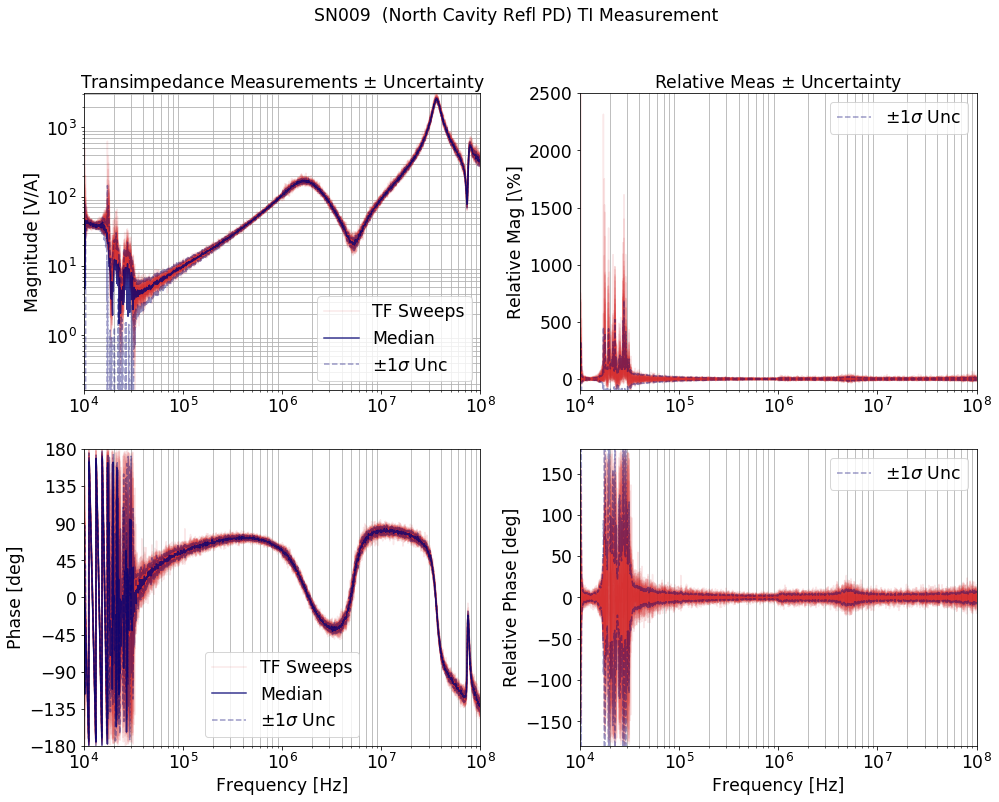

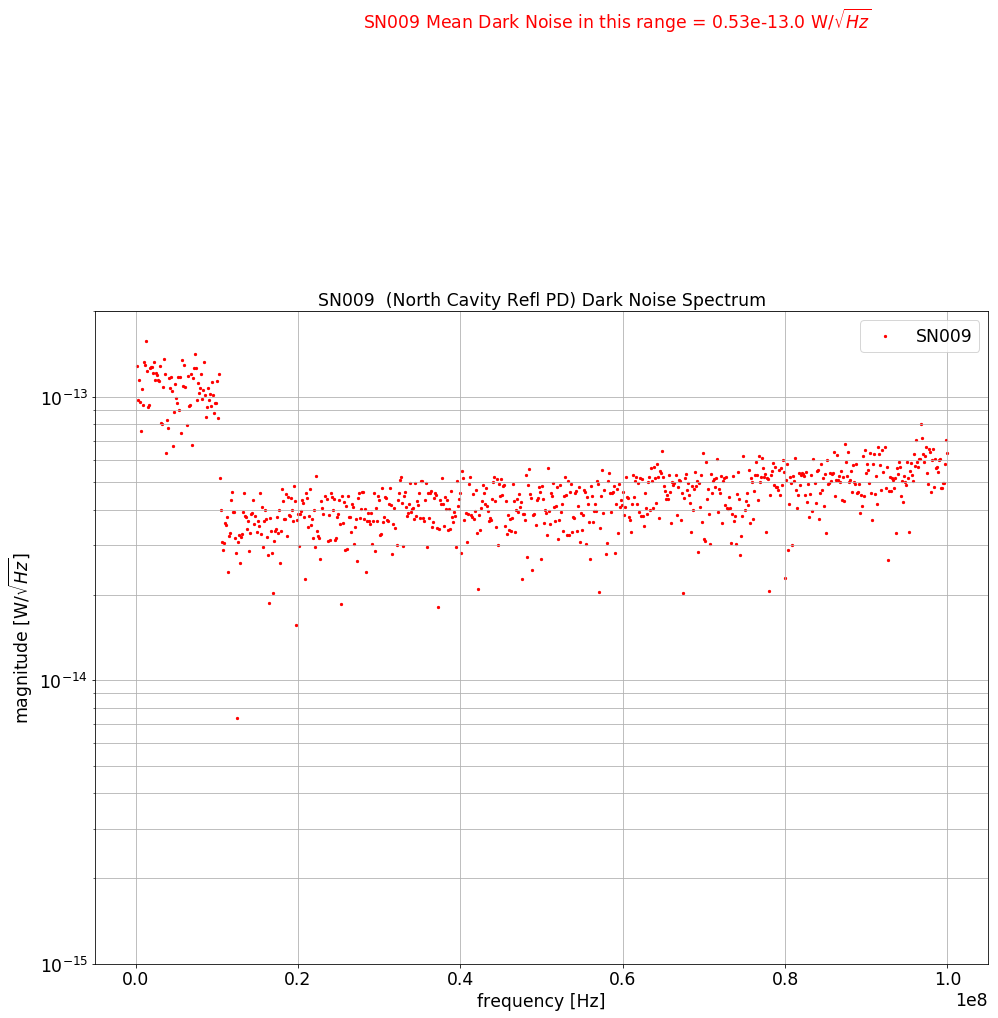

In [18]:
stitch('SN009')
SN009 = plotLikeIris('SN009','SN009  (North Cavity Refl PD)', EPL=0.125,EPLUnc = 0.01, PDVdc=291.0, PDVdcUnc = 1, RefVdc=87.6, RefVdcUnc = 0.5, PDZdc=2020.0, PDZdcUnc = 0.034*2020)
figlist += [SN009['fig']]
#figlist += [SN009['DN_fig']]

In [20]:
print(np.abs(SN009['TF'][np.argmin(np.abs(SN009['freq']-36e6))])*(70.0/50.0)*(50.0/100.0))
print(np.abs(SN009['magUnc'][np.argmin(np.abs(SN009['freq']-36e6))])*(70.0/50.0)*(50.0/100.0))

1816.166751026398
134.1688424632762


Peak Frequency = 36.67 MHz
TI at Peak Frequency = 1529.274 +/- 98.71 V/A
Notch Frequency = 74.237 MHz
TI at Notch Frequency = 76.845 +/- 8.496 V/A
TI at DC = 2222.0 +/- 75.548 V/A
Mean Dark Noise = 51.152 fW/$\sqrt{Hz}$


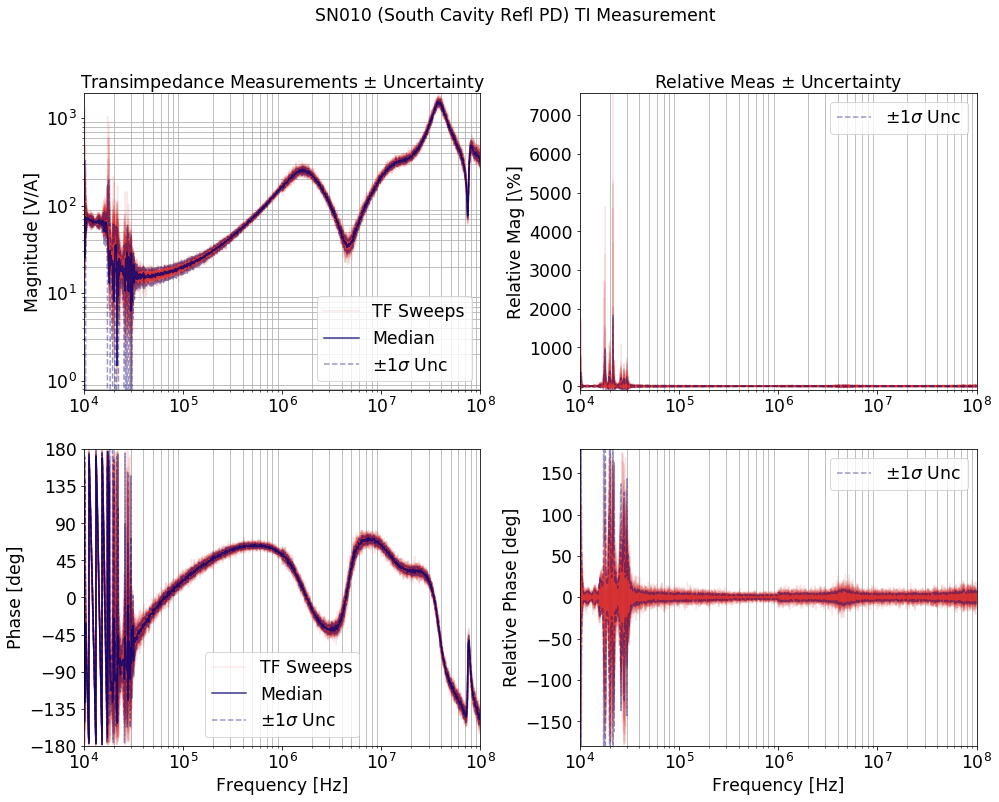

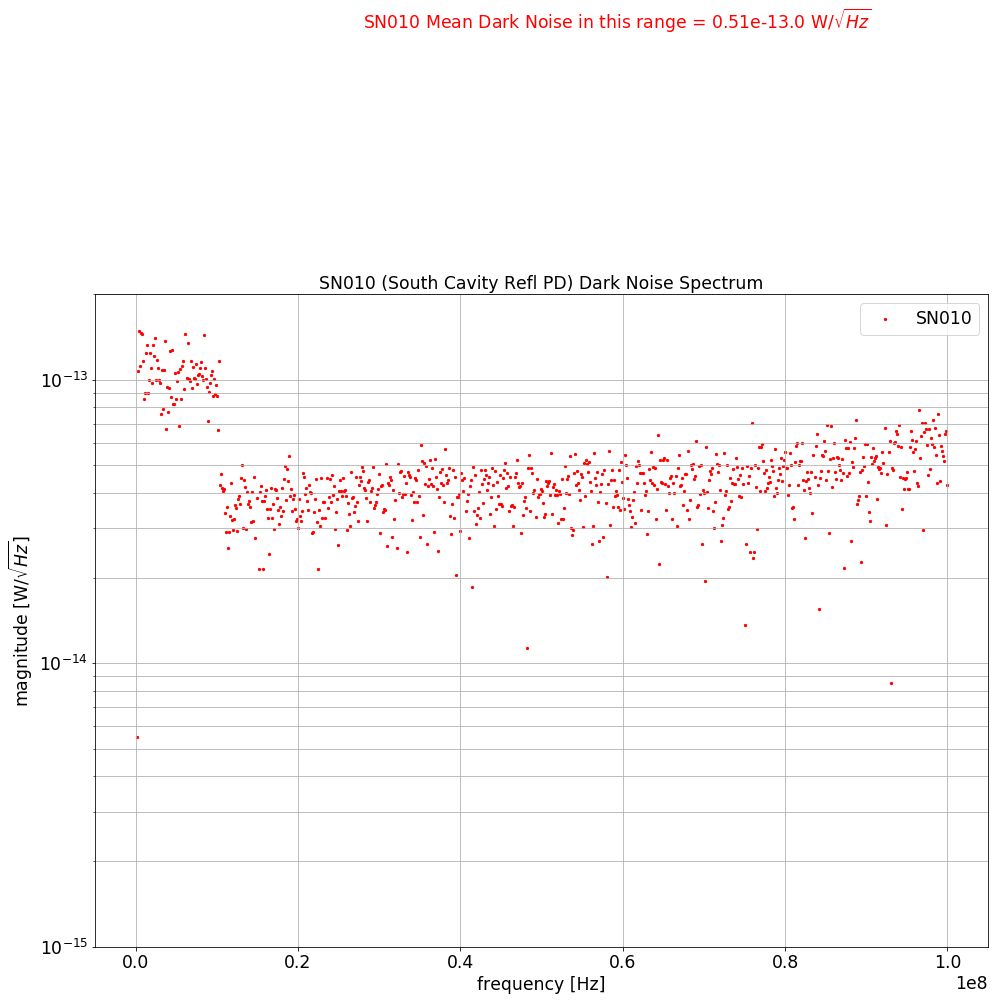

In [16]:
stitch('SN010')
SN010 = plotLikeIris('SN010','SN010 (South Cavity Refl PD)', EPL=0.125,EPLUnc = 0.01, PDVdc=209.0, PDVdcUnc = 1, RefVdc=96.5, RefVdcUnc = 0.5, PDZdc=2222.0, PDZdcUnc = 0.034*2222)
figlist += [SN010['fig']]
#figlist += [SN010['DN_fig']]

In [17]:
print(np.abs(SN010['TF'][np.argmin(np.abs(SN010['freq']-37e6))])*(0.5*113/(560.0+(113.0/2)))*((680.0+75.0)/75.0)*(70.0/50.0)*(50.0/100.0))
print(np.abs(SN010['magUnc'][np.argmin(np.abs(SN010['freq']-37e6))])*(0.5*113/(560.0+(113.0/2)))*((680.0+75.0)/75.0)*(70.0/50.0)*(50.0/100.0))

937.0804395901212
74.06299847055207


Peak Frequency = 15.107 MHz
TI at Peak Frequency = 14430.74 +/- 1255.768 V/A
Notch Frequency = 100.0 MHz
TI at Notch Frequency = 316.235 +/- 35.269 V/A
TI at DC = 2222.0 +/- 75.548 V/A
Mean Dark Noise = 54.657 fW/$\sqrt{Hz}$


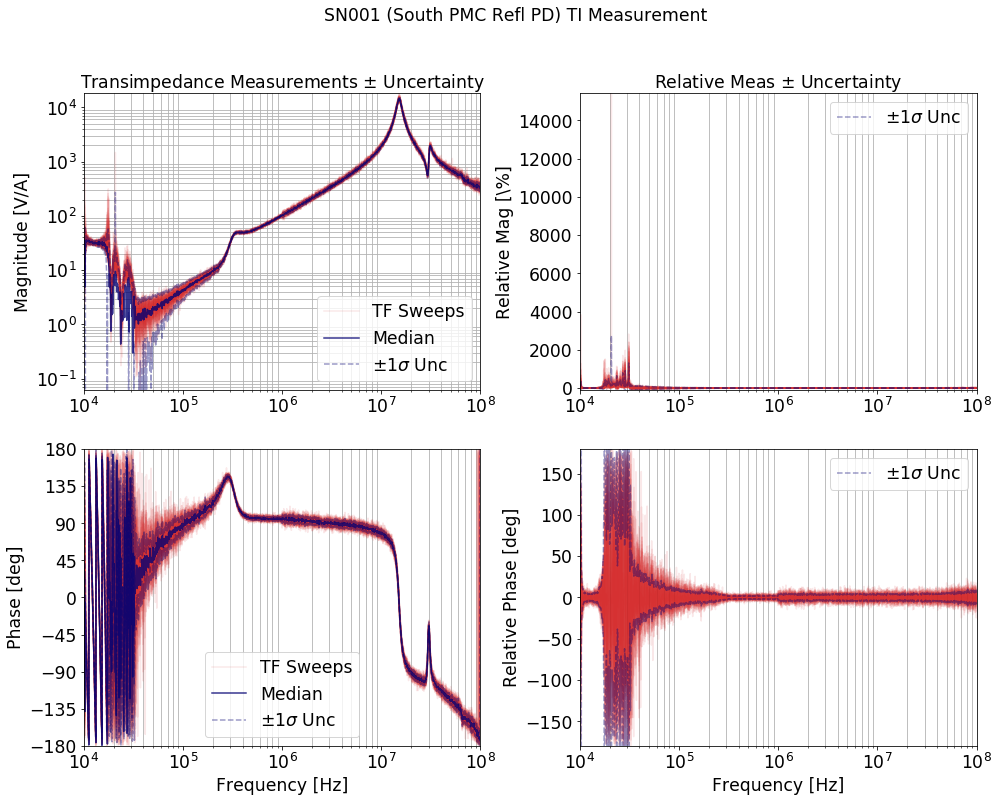

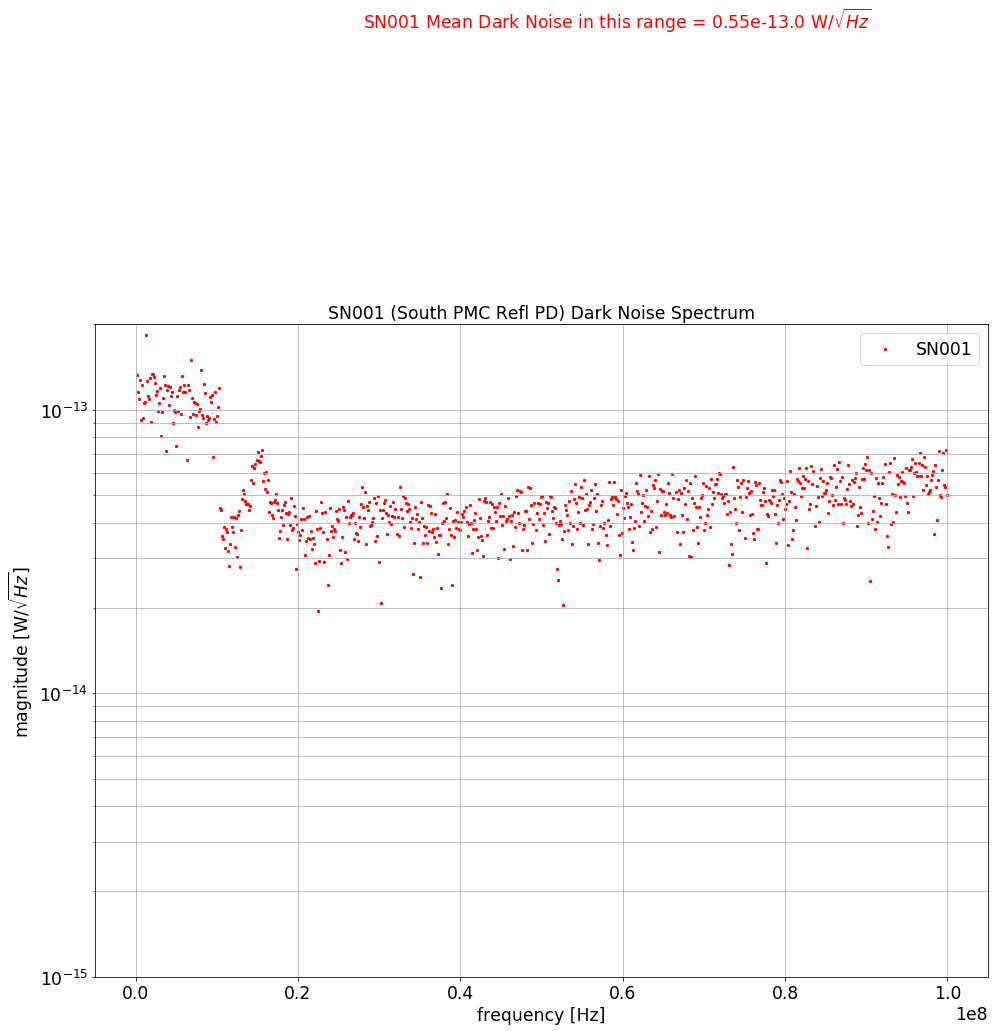

In [10]:
stitch('SN001')
SN001 = plotLikeIris('SN001','SN001 (South PMC Refl PD)', EPL=0.11, EPLUnc = 0.01, PDVdc=381.0, PDVdcUnc = 1, RefVdc=85.6, RefVdcUnc = 0.5, PDZdc=2222.0, PDZdcUnc = 0.034*2222)
figlist += [SN001['fig']]
#figlist += [SN001['DN_fig']]
#Calculated Notch frequency wrong here. Check the last cell for correct value.

In [12]:
print(np.abs(SN001['TF'][np.argmin(np.abs(SN001['freq']-14.75e6))]))
print(np.abs(SN001['magUnc'][np.argmin(np.abs(SN001['freq']-14.75e6))]))

13019.263005527462
1030.0586123808


Peak Frequency = 21.692 MHz
TI at Peak Frequency = 2891.438 +/- 248.082 V/A
Notch Frequency = 42.413 MHz
TI at Notch Frequency = 137.625 +/- 11.986 V/A
TI at DC = 2222.0 +/- 75.548 V/A
Mean Dark Noise = 52.226 fW/$\sqrt{Hz}$


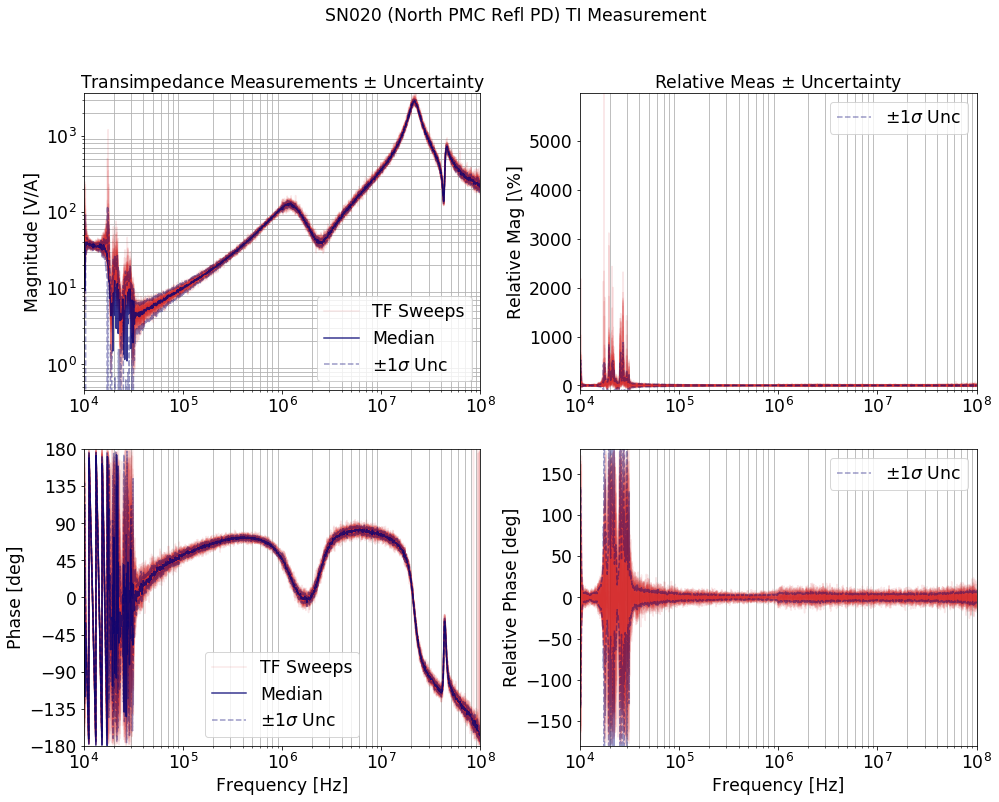

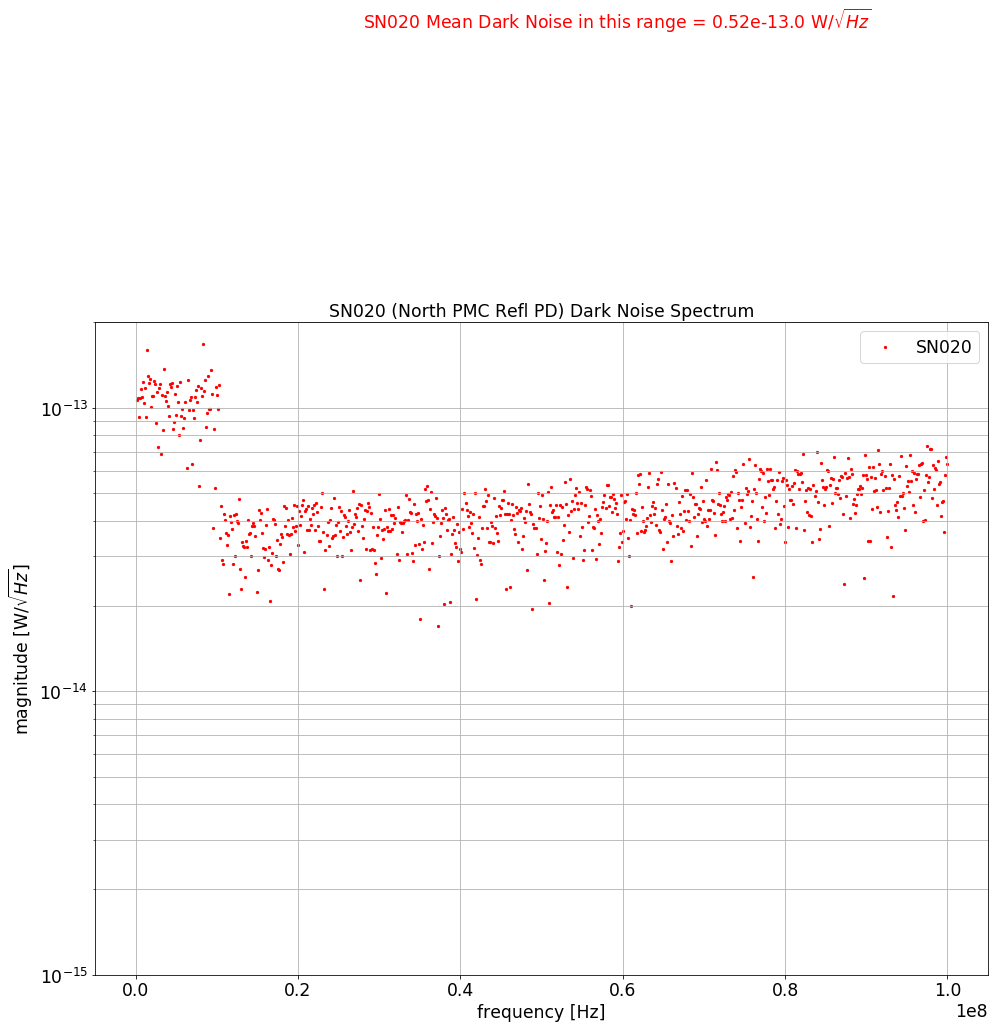

In [8]:
stitch('SN020')
SN020 = plotLikeIris('SN020','SN020 (North PMC Refl PD)', EPL=0.135, EPLUnc = 0.01, PDVdc=347.0, PDVdcUnc = 1, RefVdc=87.5, RefVdcUnc = 0.5, PDZdc=2222.0, PDZdcUnc = 0.034*2222)
figlist += [SN020['fig']]
#figlist += [SN020['DN_fig']]

In [14]:
print(np.abs(SN020['TF'][np.argmin(np.abs(SN020['freq']-21.5e6))]))
print(np.abs(SN020['magUnc'][np.argmin(np.abs(SN020['freq']-21.5e6))]))

2817.6680161411846
220.19222092920597


In [ ]:
stitch('SN101')
SN101 = plotLikeIris('SN101','SN101 (Beat Note Detector)', EPL=0.135, EPLUnc = 0.01, PDVdc=347.0, PDVdcUnc = 1, RefVdc=87.5, RefVdcUnc = 0.5, PDZdc=1010.0, PDZdcUnc = 0.034*1010)
figlist += [SN101['fig']]
#figlist += [SN101['DN_fig']]
#There is no notch in this RFPD. So ignore the notch details.

In [ ]:
CavReflPD_Fig = overlayPlot(SN009,SN010,'Cavity Reflection PDs (SN009: North, SN010: South) Transimpedance')
figlist +=[CavReflPD_Fig]

In [ ]:
PMCReflPD_Fig = overlayPlot(SN020,SN001,'PMC Reflection PDs (SN020: North, SN001: South) Transimpedance')
figlist +=[PMCReflPD_Fig]

In [ ]:
CavReflPD_DN = overlayDarkNoise(SN009,SN010,'Cavity Reflection PDs (SN009: North, SN010: South) Dark Noise')
#figlist +=[CavReflPD_DN]

In [ ]:
PMCReflPD_DN = overlayDarkNoise(SN020,SN001,'PMC Reflection PDs (SN020: North, SN001: South) Dark Noise')
#figlist +=[PMCReflPD_DN]

In [ ]:
pp = PdfPages('All_RFPD_TI_and_Dark_Noise_Measurements.pdf')
for fg in figlist:
    pp.savefig(fg,bbox_inches='tight')
pp.close()

In [ ]:
SN001['notchFreqInd']=SN001['peakFreqInd']+np.argmin(np.abs(SN001['TF'][SN001['peakFreqInd']:SN001['peakFreqInd']+150]))
SN001['notchFreq'] = SN001['freq'][SN001['notchFreqInd']]
SN001['notchFreqTI'] = np.abs(SN001['TF'][SN001['notchFreqInd']])
SN001['notchFreqTIUnc'] = np.abs(SN001['magUnc'][SN001['notchFreqInd']])
print('Notch Frequecy = '+str(np.round(SN001['notchFreq']/1e6,3))+' MHz')
print('TI at Notch Frequency = '+str(np.round(SN001['notchFreqTI'],3))+' +/- '+str(np.round(SN001['notchFreqTIUnc'],3))+ ' V/A')